In [1]:
from dotenv import load_dotenv
import os
import pandas as pd
from pyoso import Client

In [2]:
load_dotenv()
OSO_API_KEY = os.environ['OSO_API_KEY']
client = Client(api_key=OSO_API_KEY)
stringify = lambda arr: "'" + "','".join(arr) + "'"

In [3]:
df_social = client.to_pandas("""

WITH social AS (
  SELECT 
    id,
    source_id,
    company_name,
    'TWITTER' AS artifact_source,
    REGEXP_EXTRACT(artifact_url, '(?:twitter|x)\\.com/([^/?#]+)', 1) AS artifact_owner,
    artifact_url
  FROM dynamic.oso.coresignal_company_data
  CROSS JOIN UNNEST(CAST(twitter_url AS ARRAY(VARCHAR))) AS t(artifact_url)

  UNION ALL

  SELECT 
    id,
    source_id,
    company_name,
    'GITHUB' AS artifact_source,
    REGEXP_EXTRACT(artifact_url, 'github\\.com/([^/?#]+)', 1) AS artifact_owner,
    artifact_url
  FROM dynamic.oso.coresignal_company_data
  CROSS JOIN UNNEST(CAST(github_url AS ARRAY(VARCHAR))) AS g(artifact_url)
),

normalized AS (
  SELECT DISTINCT
    id,
    source_id,
    company_name,
    artifact_source,
    artifact_owner
  FROM social
),

abp AS (
   SELECT DISTINCT
     project_id,
     project_name,
     project_source,
     artifact_source,
     CASE
       WHEN artifact_source = 'GITHUB' THEN artifact_namespace
       ELSE artifact_name
     END AS artifact_owner
   FROM oso.artifacts_by_project_v1
   WHERE
     artifact_source IN ('GITHUB', 'TWITTER')
     AND project_source IN ('OSS_DIRECTORY', 'CRYPTO_ECOSYSTEMS')
     AND project_namespace IN ('oso', 'eco')
)

SELECT
  social.*,
  abp.project_id,
  abp.project_name,
  abp.project_source
FROM social
LEFT JOIN abp
ON
  social.artifact_source = abp.artifact_source
  AND social.artifact_owner = abp.artifact_owner
""")

df_social.tail()

,id,source_id,company_name,artifact_source,artifact_owner,artifact_url,project_id,project_name,project_source
927,11955459,27137803,StarkWare,GITHUB,starkware-libs,https://github.com/starkware-libs/,lNqoII6wtI94+eO0CQYs64TYxfEDEbO0zoe0jvkx76A=,evm_compatible_l1_and_l2,CRYPTO_ECOSYSTEMS
928,11955459,27137803,StarkWare,GITHUB,starkware-libs,https://github.com/starkware-libs/,djOtUQeW/loZ+Lqh23zgOwkd8gWOVzU7V1avY/dYucM=,starkware,CRYPTO_ECOSYSTEMS
929,11955459,27137803,StarkWare,GITHUB,starkware-libs,https://github.com/starkware-libs/,qpiHJg+5NXEuPhvKFQqvYgZMupR3PUYwz9tSaRiPtSk=,ethereum_virtual_machine_stack,CRYPTO_ECOSYSTEMS
930,11955459,27137803,StarkWare,GITHUB,starkware-libs,https://github.com/starkware-libs/,vIQVpiYSnNCNRhmm4tb7KhrewmKY8Dr6nN93dtkuqUU=,general,CRYPTO_ECOSYSTEMS
931,11955459,27137803,StarkWare,GITHUB,starkware-libs,https://github.com/starkware-libs/,YsfvQxS1Dmj0Zvg7NevlHd/+HKFPDuaY079FvYeSsAc=,starknet,CRYPTO_ECOSYSTEMS


In [4]:
df_social[df_social['project_source'].notnull()].groupby('company_name')['project_source'].unique()

company_name
Across Protocol            [OSS_DIRECTORY, CRYPTO_ECOSYSTEMS]
Aevo                       [CRYPTO_ECOSYSTEMS, OSS_DIRECTORY]
Axiom                      [CRYPTO_ECOSYSTEMS, OSS_DIRECTORY]
Babylon Labs                              [CRYPTO_ECOSYSTEMS]
Category Labs                                 [OSS_DIRECTORY]
Conduit                                       [OSS_DIRECTORY]
Farcaster                  [OSS_DIRECTORY, CRYPTO_ECOSYSTEMS]
Flashbots                  [CRYPTO_ECOSYSTEMS, OSS_DIRECTORY]
IGNITE                                    [CRYPTO_ECOSYSTEMS]
Lido Finance               [OSS_DIRECTORY, CRYPTO_ECOSYSTEMS]
Lightspark                                [CRYPTO_ECOSYSTEMS]
Numerai                                   [CRYPTO_ECOSYSTEMS]
Optimism Foundation        [OSS_DIRECTORY, CRYPTO_ECOSYSTEMS]
Privy                      [OSS_DIRECTORY, CRYPTO_ECOSYSTEMS]
Ready (formerly Argent)    [CRYPTO_ECOSYSTEMS, OSS_DIRECTORY]
Reflexer Labs              [CRYPTO_ECOSYSTEMS, OSS_DIRECT

In [5]:
project_ids = df_social[df_social['project_source'] == 'OSS_DIRECTORY']['project_id'].unique()
df_metrics = client.to_pandas(f"""
SELECT
  sample_date,
  project_id,
  amount
FROM timeseries_metrics_by_project_v0
JOIN metrics_v0 USING metric_id
WHERE
  project_id IN ({stringify(project_ids)})
  AND metric_name = 'GITHUB_active_developers_monthly'
""")
df_metrics

,sample_date,project_id,amount
0,2015-09-01,CgkycgswSzo7Brgjj4YzC6Gbc0QVAof11N2O2WIjBPc=,5
1,2015-09-01,k6zRH9KxxI0T5WynhD3Rp0ziptk7KZ02O6+oB54ppiI=,1
2,2015-09-01,xZBoQciQXIw5xZtAITyCe2bTrLHnwKv8Ps7Hhu4eBH4=,2
3,2015-09-01,vD6QgU2nKpWiutcCnblDJkVHtDkLDH6oyITV+xpe3+g=,2
4,2015-09-01,Cn4LnfscnqeswZETDHcax6WtmPFyrNJmAknJ6hNuRtQ=,23
...,...,...,...
2319,2025-02-01,JVxPdLa4HkEyVsPqDaBpZLQKMaxKLkhHtP8DM1Hc4Ho=,2
2320,2025-02-01,NgP0Wx6bYjRNFem2uqgwQDgI7uEir12R/KBBDSHZBzY=,7
2321,2025-02-01,up2MCAf75n3h1mqBH/puN9wEuJnTWuoaCdBY9A5/Kww=,7
2322,2025-05-01,/tZOhveeZLBHY4bD+zn1WaRDnF/FCiHwVtuN9q+dKgE=,2


In [6]:
df_funding = client.to_pandas("""

WITH
  base AS (
    SELECT id,source_id,company_name,CAST(funding_rounds AS ARRAY(JSON)) AS rounds
    FROM dynamic.oso.coresignal_company_data
  ), 
  normalized AS (
    SELECT
      b.id,
      b.source_id,
      b.company_name,
      JSON_EXTRACT_SCALAR(r,'$.name') AS funding_round_name,
      JSON_EXTRACT_SCALAR(r,'$.announced_date') AS announced_date,
      TRY_CAST(REGEXP_REPLACE(JSON_EXTRACT_SCALAR(r,'$.amount_raised'),'[, ]','') AS DOUBLE) AS amount_raised,
      JSON_EXTRACT_SCALAR(r,'$.amount_raised_currency') AS currency,
      TRY_CAST(JSON_EXTRACT_SCALAR(r,'$.num_investors') AS INTEGER) AS num_investors,
      g.lead_investor
    FROM base AS b
    CROSS JOIN UNNEST(b.rounds) AS u(r)
    LEFT JOIN UNNEST(
      COALESCE(
        CAST(JSON_EXTRACT(r,'$.lead_investors') AS ARRAY(VARCHAR)),
        CAST(ARRAY[] AS ARRAY(VARCHAR))
      )
    ) AS g(lead_investor) ON TRUE
  )
  SELECT
    id,
    source_id,
    company_name,
    announced_date,
    funding_round_name,
    lead_investor,
    num_investors,
    amount_raised
  FROM normalized
  WHERE currency IN ('USD', '$')
""")

df_funding.tail()

,id,source_id,company_name,announced_date,funding_round_name,lead_investor,num_investors,amount_raised
615,88844498,82289134,Landeed | YC,2022-08-10,Pre Seed Round - Landeed,Goodwater Capital,9,2461165
616,88844498,82289134,Landeed | YC,2022-08-10,Pre Seed Round - Landeed,Justin Hamilton,9,2461165
617,88844498,82289134,Landeed | YC,2022-08-10,Pre Seed Round - Landeed,Kunal Shah,9,2461165
618,88844498,82289134,Landeed | YC,2022-08-10,Pre Seed Round - Landeed,Manmohan Chandolu,9,2461165
619,88844498,82289134,Landeed | YC,2022-08-10,Pre Seed Round - Landeed,Olive Tree Holdings,9,2461165


In [7]:
df_funding_merged = df_funding.merge(df_social[['id', 'project_id']], on='id')
df_funding_merged = df_funding_merged[df_funding_merged['project_id'].isin(project_ids)]
df_funding_merged

,id,source_id,company_name,announced_date,funding_round_name,lead_investor,num_investors,amount_raised,project_id
190,81779390,75574122,Flashbots,2023-07-21,Series B - Flashbots,Paradigm,1,60000000,COzt7X/yHkN0asBsyS5SPcqgGiku2VYG6PTdAt7Os3s=
203,81779390,75574122,Flashbots,2023-07-21,Series B - Flashbots,Paradigm,1,60000000,COzt7X/yHkN0asBsyS5SPcqgGiku2VYG6PTdAt7Os3s=
210,81779390,75574122,Flashbots,2023-07-21,Series B - Flashbots,Paradigm,1,60000000,DHE5cDCNUxZDaC/GOxvLwKhwqRw5wYTCZ5/+WUVE2rA=
211,81779390,75574122,Flashbots,2023-07-21,Series B - Flashbots,Paradigm,1,60000000,Z8vbH9DeT+kcmThLMbMqJ3SYY3RjCfD0E6VUWro71Lo=
212,81779390,75574122,Flashbots,2023-07-21,Series B - Flashbots,Paradigm,1,60000000,aZuCfIyTIiei7b35oj5YFtMJ9vav9mmzl/35xLmdGgM=
...,...,...,...,...,...,...,...,...,...
2637,88705299,86632358,Lido Finance,2021-05-05,Initial Coin Offering - Lido,Paradigm,1,51000000,i/gSAlLU7P+FhIOzDQEk2+c5aOXKLmzAQILG8vqqJOE=
2650,88705299,86632358,Lido Finance,2022-09-14,Venture Round - Lido,Dragonfly Capital,1,24000000,i/gSAlLU7P+FhIOzDQEk2+c5aOXKLmzAQILG8vqqJOE=
2669,88705299,86632358,Lido Finance,2022-09-14,Venture Round - Lido,Dragonfly Capital,1,24000000,i/gSAlLU7P+FhIOzDQEk2+c5aOXKLmzAQILG8vqqJOE=
2698,88705299,86632358,Lido Finance,2022-09-14,Venture Round - Lido,Dragonfly Capital,1,24000000,i/gSAlLU7P+FhIOzDQEk2+c5aOXKLmzAQILG8vqqJOE=


In [8]:
df_funding_merged.groupby('lead_investor')['amount_raised'].sum().sort_values(ascending=False)

lead_investor
Paradigm               4461559937
Andreessen Horowitz     895000000
Dragonfly Capital       192000000
Haun Ventures           124000000
DWF Labs                 80000000
Coinbase Ventures        77000000
IOSG Ventures            48000000
Fabric Ventures          40000000
Metaplanet               40000000
Pantera Capital          37280000
Ribbit Capital           30000000
Standard Crypto          20000000
Dragonfly                19000000
BlueYard Capital         16600000
Sequoia Capital          16600000
Framework Ventures       15200000
Lemniscap                 8280000
cyber•Fund                5800000
Kindred Ventures          2000000
Name: amount_raised, dtype: Int64

In [9]:
def analyze_investor(lead_investor):
    dff_funding = df_funding_merged[df_funding_merged['lead_investor'] == lead_investor]
    _project_ids = df_funding_merged['project_id'].unique()
    dff_metrics = df_metrics[df_metrics['project_id'].isin(_project_ids)]

    grp_funding = (
        dff_funding
        .groupby('announced_date', as_index=False)['amount_raised']
        .sum()
        .rename(columns={
            'announced_date': 'sample_date',
            'amount_raised': 'amount'
        })
        .assign(event_type='INVESTMENT')
        .sort_values(by='sample_date')
    )
    grp_funding['normalized_amount'] = grp_funding['amount'].cumsum() / grp_funding['amount'].sum()

    grp_metrics = (
        dff_metrics
        .groupby('sample_date', as_index=False)['amount']
        .sum()
        .assign(event_type='DEVELOPERS')
    )
    grp_metrics['normalized_amount'] = grp_metrics['amount'] / grp_metrics['amount'].max()

    return pd.concat([grp_funding, grp_metrics], axis=0)


analyze_investor('Andreessen Horowitz')    

,sample_date,amount,event_type,normalized_amount
0,2021-02-24,75000000,INVESTMENT,0.083799
1,2022-03-03,280000000,INVESTMENT,0.396648
2,2022-03-17,450000000,INVESTMENT,0.899441
3,2022-07-13,90000000,INVESTMENT,1.0
0,2015-01-01,10,DEVELOPERS,0.035336
...,...,...,...,...
123,2025-04-01,279,DEVELOPERS,0.985866
124,2025-05-01,241,DEVELOPERS,0.85159
125,2025-06-01,203,DEVELOPERS,0.717314
126,2025-07-01,189,DEVELOPERS,0.667845


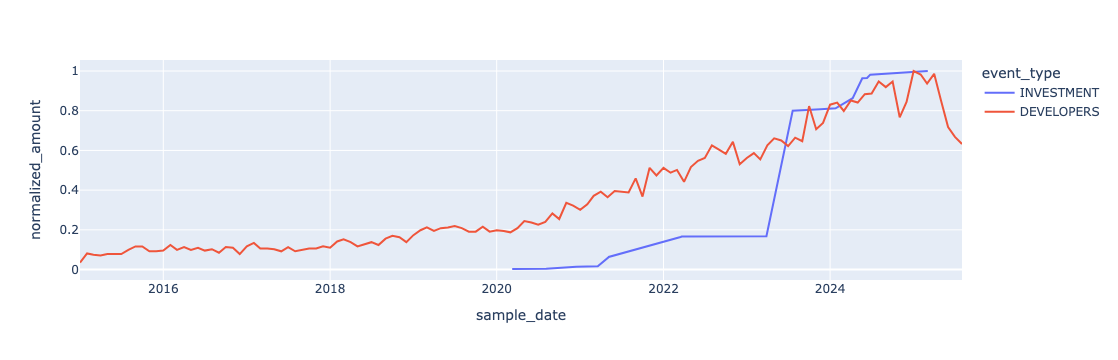

In [10]:
import plotly.express as px
px.line(
    data_frame=analyze_investor('Paradigm'),
    x='sample_date',
    y='normalized_amount',
    color='event_type'
)